In [1]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [218]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = (1-2*np.random.rand(2*(N+M+N*M)))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Conjugate Gradient Descent
class ConGradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [192]:
#Conjugate Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par,lr):
        gtol = 1e-04
        maxIter = 200*len(par)
        H = self.hamiltonian
        partials = gradEnergy(par,N, M,H)
        partialsNorm = np.linalg.norm(partials)
        iteration = 0
        iterationData = []
        while(partialsNorm>gtol and iteration<maxIter):
            iteration += 1
            print('Iter: ',iteration)
            par = par -(lr)*partials
            iterationData.append(par)
            partials = gradEnergy(par,N, M,H)
            partialsNorm = np.linalg.norm(partials)
            print('Norm: ', partialsNorm)
            print('Energy: ', varEnergy(par, N, M,H))
        print('Optimization terminated successfully')
        #Ground State
        found_gs = RBM_ansatz(par,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(par, N, M,H)
        print('Found Energy: ', found_gsEnergy)
        print('Numer of Iterations: ', iteration)
        return iterationData, found_gs, found_gsEnergy  

In [197]:
#Conjugate Gradient Descent
class GradDescentMomentum:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par,lr,gamma):
        gtol = 1e-04
        maxIter = 200*len(par)
        H = self.hamiltonian
        partials = gradEnergy(par,N, M,H)
        partialsNorm = np.linalg.norm(partials)
        iteration = 0
        momentum = 0
        iterationData = []
        while(partialsNorm>gtol and iteration<maxIter):
            iteration += 1
            print('Iter: ',iteration)
            momentum = gamma* momentum-(lr)*partials
            par = par + momentum
            iterationData.append(par)
            partials = gradEnergy(par,N, M,H)
            partialsNorm = np.linalg.norm(partials)
            print('Norm: ', partialsNorm)
            print('Energy: ', varEnergy(par, N, M,H))
        print('Optimization terminated successfully')
        #Ground State
        found_gs = RBM_ansatz(par,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(par, N, M,H)
        print('Found Energy: ', found_gsEnergy)
        print('Numer of Iterations: ', iteration)
        return iterationData, found_gs, found_gsEnergy  

In [172]:
#NelderMead
class NelderMead:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='nelder-mead', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [173]:
#BFGS
class BFGS:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [174]:
#Newton-CG
class NewtonCG:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='Newton-CG', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [175]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [176]:
#Loader to test different methods with same RBM initalization
def minLoader(minimizer, N, M, B, A0):
    par = ranRBMpar(N,M)
    if minimizer == 'GradDescent':
        gradDescent = GradDescent(N, B, A0)
        gd = gradDescent(N, M,par)
        return gd
    if minimizer == "NelderMead":
        nelderMead = NelderMead(N,B,A0)
        nm = nelderMead(N,M,par)
        return nm
    if minimizer == "BFGS":
        bfgs = BFGS(N,B,A0)
        bf = bfgs(N,M,par)
        return bf
        
        
    

## Other Minimization Testing

In [257]:
N=2
M=1
B = 1
A0 = 1

In [258]:
par = ranRBMpar(N,M)
H = hamiltonian(N, B, A0)


In [259]:
gradDescent = GradDescent(N, B, A0)
GD = gradDescent(N,M,par,0.6)

Iter:  1
Norm:  0.645134510514727
Energy:  -0.29342102286220584
Iter:  2
Norm:  0.48468483118158323
Energy:  -0.5152524662824691
Iter:  3
Norm:  0.313181923560972
Energy:  -0.630533668954697
Iter:  4
Norm:  0.22117832393273468
Energy:  -0.6802557043467992
Iter:  5
Norm:  0.17098940758204284
Energy:  -0.7060865961528463
Iter:  6
Norm:  0.1409478324495361
Energy:  -0.7219940841855115
Iter:  7
Norm:  0.12196526607949351
Energy:  -0.7330545979302787
Iter:  8
Norm:  0.10982177204203983
Energy:  -0.7414961734615461
Iter:  9
Norm:  0.10234358714457215
Energy:  -0.7484560635310805
Iter:  10
Norm:  0.09831806454148745
Energy:  -0.7545923459634892
Iter:  11
Norm:  0.09702718456464075
Energy:  -0.7603332490499997
Iter:  12
Norm:  0.09802546964010257
Energy:  -0.7659927666694407
Iter:  13
Norm:  0.1010208679241369
Energy:  -0.7718304001474905
Iter:  14
Norm:  0.10579515420401585
Energy:  -0.778084434166996
Iter:  15
Norm:  0.11212724027742817
Energy:  -0.7849894396044087
Iter:  16
Norm:  0.1196906

Norm:  0.006026690272537964
Energy:  -0.956439029567749
Iter:  127
Norm:  0.005934458909051955
Energy:  -0.9564594949373634
Iter:  128
Norm:  0.0058439283198971756
Energy:  -0.9564793185318021
Iter:  129
Norm:  0.005755054414229678
Energy:  -0.9564985220462354
Iter:  130
Norm:  0.005667794771907466
Energy:  -0.9565171263327399
Iter:  131
Norm:  0.005582108562532427
Energy:  -0.9565351514396975
Iter:  132
Norm:  0.0054979564670091545
Energy:  -0.9565526166489878
Iter:  133
Norm:  0.00541530060466428
Energy:  -0.9565695405110946
Iter:  134
Norm:  0.005334104466057387
Energy:  -0.9565859408782732
Iter:  135
Norm:  0.005254332846428706
Energy:  -0.9566018349359157
Iter:  136
Norm:  0.005175951785006007
Energy:  -0.9566172392322096
Iter:  137
Norm:  0.0050989285068583955
Energy:  -0.9566321697062091
Iter:  138
Norm:  0.005023231370070607
Energy:  -0.956646641714416
Iter:  139
Norm:  0.004948829812265189
Energy:  -0.9566606700559753
Iter:  140
Norm:  0.004875694302395043
Energy:  -0.95667426

Norm:  0.0011178670978394694
Energy:  -0.9570919448439653
Iter:  247
Norm:  0.0011036060025502612
Energy:  -0.9570924017799919
Iter:  248
Norm:  0.0010895649514353408
Energy:  -0.9570928428179161
Iter:  249
Norm:  0.0010757410631665161
Energy:  -0.9570932684460053
Iter:  250
Norm:  0.0010621314972882262
Energy:  -0.9570936791382918
Iter:  251
Norm:  0.0010487334556414272
Energy:  -0.9570940753549751
Iter:  252
Norm:  0.0010355441804890365
Energy:  -0.9570944575428222
Iter:  253
Norm:  0.0010225609528840475
Energy:  -0.9570948261355471
Iter:  254
Norm:  0.0010097810942231765
Energy:  -0.9570951815541894
Iter:  255
Norm:  0.0009972019623687343
Energy:  -0.9570955242074719
Iter:  256
Norm:  0.000984820953890765
Energy:  -0.9570958544921565
Iter:  257
Norm:  0.0009726355014033002
Energy:  -0.9570961727933839
Iter:  258
Norm:  0.0009606430733336075
Energy:  -0.9570964794850083
Iter:  259
Norm:  0.0009488411733190584
Energy:  -0.9570967749299162
Iter:  260
Norm:  0.0009372273399595395
Energy

Norm:  0.000392781988833513
Energy:  -0.9571024477118137
Iter:  371
Norm:  0.00039162701417368796
Energy:  -0.9571024305426346
Iter:  372
Norm:  0.0003905018401606821
Energy:  -0.9571024133628209
Iter:  373
Norm:  0.0003894057793930862
Energy:  -0.9571023961803075
Iter:  374
Norm:  0.00038833815619771395
Energy:  -0.9571023790026932
Iter:  375
Norm:  0.00038729830893790727
Energy:  -0.9571023618372555
Iter:  376
Norm:  0.0003862855855820779
Energy:  -0.9571023446909557
Iter:  377
Norm:  0.00038529934677497405
Energy:  -0.9571023275704555
Iter:  378
Norm:  0.00038433896732089555
Energy:  -0.9571023104821226
Iter:  379
Norm:  0.00038340383109779805
Energy:  -0.9571022934320423
Iter:  380
Norm:  0.0003824933355530137
Energy:  -0.957102276426026
Iter:  381
Norm:  0.0003816068885557445
Energy:  -0.9571022594696216
Iter:  382
Norm:  0.0003807439109477199
Energy:  -0.9571022425681209
Iter:  383
Norm:  0.00037990383465383776
Energy:  -0.9571022257265693
Iter:  384
Norm:  0.00037908610227283283

Norm:  0.0003517603432126946
Energy:  -0.9571010649217809
Iter:  494
Norm:  0.00035172700154929257
Energy:  -0.9571010601756151
Iter:  495
Norm:  0.0003516946742130158
Energy:  -0.9571010555033942
Iter:  496
Norm:  0.0003516633302220502
Energy:  -0.9571010509042436
Iter:  497
Norm:  0.00035163294183568566
Energy:  -0.9571010463772988
Iter:  498
Norm:  0.0003516034818301885
Energy:  -0.9571010419216996
Iter:  499
Norm:  0.00035157492177117486
Energy:  -0.9571010375365921
Iter:  500
Norm:  0.00035154723704123946
Energy:  -0.9571010332211317
Iter:  501
Norm:  0.0003515204012990756
Energy:  -0.9571010289744766
Iter:  502
Norm:  0.0003514943897640704
Energy:  -0.9571010247957941
Iter:  503
Norm:  0.0003514691794303848
Energy:  -0.9571010206842581
Iter:  504
Norm:  0.00035144474597032725
Energy:  -0.9571010166390485
Iter:  505
Norm:  0.00035142106793268127
Energy:  -0.957101012659353
Iter:  506
Norm:  0.00035139812170638824
Energy:  -0.9571010087443653
Iter:  507
Norm:  0.0003513758870303967

Norm:  0.00035076913686670885
Energy:  -0.9571008339200165
Iter:  613
Norm:  0.0003507694124333019
Energy:  -0.9571008336560555
Iter:  614
Norm:  0.00035076971628262286
Energy:  -0.9571008334064386
Iter:  615
Norm:  0.0003507700486585243
Energy:  -0.9571008331709533
Iter:  616
Norm:  0.00035077040742532083
Energy:  -0.9571008329493877
Iter:  617
Norm:  0.0003507707914172177
Energy:  -0.9571008327415357
Iter:  618
Norm:  0.0003507712008260864
Energy:  -0.957100832547192
Iter:  619
Norm:  0.0003507716341628267
Energy:  -0.9571008323661551
Iter:  620
Norm:  0.0003507720914069149
Energy:  -0.9571008321982267
Iter:  621
Norm:  0.0003507725714569406
Energy:  -0.9571008320432104
Iter:  622
Norm:  0.000350773073485347
Energy:  -0.957100831900913
Iter:  623
Norm:  0.0003507735976192436
Energy:  -0.9571008317711442
Iter:  624
Norm:  0.0003507741418905635
Energy:  -0.9571008316537155
Iter:  625
Norm:  0.00035077470609934337
Energy:  -0.9571008315484423
Iter:  626
Norm:  0.00035077529091549097
Ene

Norm:  0.0003508870654130815
Energy:  -0.9571008648305251
Iter:  736
Norm:  0.00035088823585207023
Energy:  -0.9571008653608897
Iter:  737
Norm:  0.00035088940794610274
Energy:  -0.9571008658932504
Iter:  738
Norm:  0.00035089057885114743
Energy:  -0.9571008664275708
Iter:  739
Norm:  0.00035089175126065393
Energy:  -0.9571008669638181
Iter:  740
Norm:  0.0003508929232210501
Energy:  -0.9571008675019573
Iter:  741
Norm:  0.000350894096163632
Energy:  -0.9571008680419563
Iter:  742
Norm:  0.0003508952692360724
Energy:  -0.9571008685837811
Iter:  743
Norm:  0.0003508964429011508
Energy:  -0.9571008691273994
Iter:  744
Norm:  0.00035089761618091095
Energy:  -0.9571008696727796
Iter:  745
Norm:  0.00035089879074619757
Energy:  -0.9571008702198908
Iter:  746
Norm:  0.0003508999647733585
Energy:  -0.9571008707687004
Iter:  747
Norm:  0.0003509011396728438
Energy:  -0.9571008713191804
Iter:  748
Norm:  0.00035090231443455646
Energy:  -0.9571008718712981
Iter:  749
Norm:  0.0003509034891991926

Norm:  0.0003510281488260918
Energy:  -0.9571009360845396
Iter:  856
Norm:  0.0003510293196572164
Energy:  -0.9571009367055715
Iter:  857
Norm:  0.0003510304909484048
Energy:  -0.9571009373266671
Iter:  858
Norm:  0.0003510316628843542
Energy:  -0.9571009379478208
Iter:  859
Norm:  0.00035103283406569133
Energy:  -0.9571009385690264
Iter:  860
Norm:  0.0003510340054325581
Energy:  -0.9571009391902796
Iter:  861
Norm:  0.00035103517578726206
Energy:  -0.9571009398115743
Iter:  862
Norm:  0.00035103634639814573
Energy:  -0.9571009404329059
Iter:  863
Norm:  0.0003510375172882138
Energy:  -0.9571009410542696
Iter:  864
Norm:  0.00035103868822658463
Energy:  -0.9571009416756598
Iter:  865
Norm:  0.00035103985864250485
Energy:  -0.9571009422970718
Iter:  866
Norm:  0.00035104102889755244
Energy:  -0.9571009429185006
Iter:  867
Norm:  0.00035104219950368547
Energy:  -0.9571009435399422
Iter:  868
Norm:  0.00035104336971221846
Energy:  -0.9571009441613905
Iter:  869
Norm:  0.00035104453960580

Norm:  0.0003511713688930676
Energy:  -0.9571010118486896
Iter:  979
Norm:  0.00035117252652880647
Energy:  -0.9571010124536596
Iter:  980
Norm:  0.00035117368349663666
Energy:  -0.957101013058395
Iter:  981
Norm:  0.0003511748405605966
Energy:  -0.9571010136628951
Iter:  982
Norm:  0.0003511759979934407
Energy:  -0.9571010142671587
Iter:  983
Norm:  0.00035117715425160047
Energy:  -0.9571010148711848
Iter:  984
Norm:  0.00035117831127638423
Energy:  -0.9571010154749738
Iter:  985
Norm:  0.0003511794679544075
Energy:  -0.9571010160785238
Iter:  986
Norm:  0.0003511806245116446
Energy:  -0.957101016681835
Iter:  987
Norm:  0.0003511817806750582
Energy:  -0.9571010172849058
Iter:  988
Norm:  0.00035118293728153934
Energy:  -0.9571010178877368
Iter:  989
Norm:  0.0003511840931386906
Energy:  -0.957101018490326
Iter:  990
Norm:  0.0003511852495488131
Energy:  -0.9571010190926741
Iter:  991
Norm:  0.00035118640546322324
Energy:  -0.957101019694779
Iter:  992
Norm:  0.00035118756125167446
En

Norm:  0.00035131062036363256
Energy:  -0.9571010832040732
Iter:  1100
Norm:  0.0003513117649949459
Energy:  -0.9571010837775361
Iter:  1101
Norm:  0.0003513129094584919
Energy:  -0.9571010843507259
Iter:  1102
Norm:  0.00035131405407902563
Energy:  -0.9571010849236423
Iter:  1103
Norm:  0.00035131519813666343
Energy:  -0.9571010854962846
Iter:  1104
Norm:  0.0003513163416865864
Energy:  -0.9571010860686536
Iter:  1105
Norm:  0.0003513174858064701
Energy:  -0.9571010866407491
Iter:  1106
Norm:  0.00035131862949232983
Energy:  -0.9571010872125707
Iter:  1107
Norm:  0.0003513197735432874
Energy:  -0.9571010877841188
Iter:  1108
Norm:  0.0003513209167777593
Energy:  -0.9571010883553924
Iter:  1109
Norm:  0.0003513220608232636
Energy:  -0.9571010889263933
Iter:  1110
Norm:  0.0003513232040924599
Energy:  -0.9571010894971185
Iter:  1111
Norm:  0.0003513243477308299
Energy:  -0.9571010900675709
Iter:  1112
Norm:  0.0003513254903286658
Energy:  -0.9571010906377481
Iter:  1113
Norm:  0.0003513

Norm:  0.000351443850626953
Energy:  -0.957101148432688
Iter:  1217
Norm:  0.0003514449837363617
Energy:  -0.9571011489739264
Iter:  1218
Norm:  0.0003514461162104731
Energy:  -0.9571011495148891
Iter:  1219
Norm:  0.0003514472489788056
Energy:  -0.9571011500555763
Iter:  1220
Norm:  0.00035144838212544996
Energy:  -0.9571011505959878
Iter:  1221
Norm:  0.0003514495146658472
Energy:  -0.9571011511361233
Iter:  1222
Norm:  0.00035145064685531893
Energy:  -0.957101151675983
Iter:  1223
Norm:  0.0003514517798408969
Energy:  -0.9571011522155672
Iter:  1224
Norm:  0.0003514529119662496
Energy:  -0.9571011527548756
Iter:  1225
Norm:  0.0003514540446663769
Energy:  -0.9571011532939082
Iter:  1226
Norm:  0.00035145517639600195
Energy:  -0.9571011538326647
Iter:  1227
Norm:  0.00035145630842272165
Energy:  -0.9571011543711464
Iter:  1228
Norm:  0.0003514574403119192
Energy:  -0.9571011549093519
Iter:  1229
Norm:  0.00035145857245250654
Energy:  -0.9571011554472822
Iter:  1230
Norm:  0.000351459

Norm:  0.0003515802793671827
Energy:  -0.9571012119251188
Iter:  1338
Norm:  0.00035158140138106923
Energy:  -0.9571012124331154
Iter:  1339
Norm:  0.00035158252353091965
Energy:  -0.9571012129408393
Iter:  1340
Norm:  0.0003515836444084606
Energy:  -0.9571012134482889
Iter:  1341
Norm:  0.0003515847664444525
Energy:  -0.9571012139554665
Iter:  1342
Norm:  0.0003515858886777785
Energy:  -0.95710121446237
Iter:  1343
Norm:  0.0003515870099183761
Energy:  -0.957101214969
Iter:  1344
Norm:  0.0003515881315799064
Energy:  -0.9571012154753571
Iter:  1345
Norm:  0.00035158925320307805
Energy:  -0.9571012159814406
Iter:  1346
Norm:  0.0003515903743600484
Energy:  -0.957101216487251
Iter:  1347
Norm:  0.00035159149587514325
Energy:  -0.9571012169927885
Iter:  1348
Norm:  0.00035159261713117436
Energy:  -0.957101217498052
Iter:  1349
Norm:  0.00035159373808083954
Energy:  -0.9571012180030429
Iter:  1350
Norm:  0.0003515948587190137
Energy:  -0.9571012185077603
Iter:  1351
Norm:  0.0003515959803

Norm:  0.00035171209986736244
Energy:  -0.9571012699876283
Iter:  1456
Norm:  0.00035171321230422555
Energy:  -0.9571012704635241
Iter:  1457
Norm:  0.0003517143243630872
Energy:  -0.9571012709391489
Iter:  1458
Norm:  0.0003517154367265289
Energy:  -0.9571012714145032
Iter:  1459
Norm:  0.0003517165483960086
Energy:  -0.9571012718895865
Iter:  1460
Norm:  0.00035171766047987157
Energy:  -0.9571012723643997
Iter:  1461
Norm:  0.00035171877224515345
Energy:  -0.957101272838942
Iter:  1462
Norm:  0.0003517198838725337
Energy:  -0.9571012733132138
Iter:  1463
Norm:  0.0003517209960816916
Energy:  -0.9571012737872154
Iter:  1464
Norm:  0.00035172210703656755
Energy:  -0.9571012742609459
Iter:  1465
Norm:  0.00035172321929307287
Energy:  -0.9571012747344068
Iter:  1466
Norm:  0.00035172433056197973
Energy:  -0.957101275207596
Iter:  1467
Norm:  0.00035172544204175617
Energy:  -0.957101275680516
Iter:  1468
Norm:  0.0003517265532004396
Energy:  -0.9571012761531648
Iter:  1469
Norm:  0.000351

Norm:  0.0003518450190510988
Energy:  -0.9571013251688327
Iter:  1576
Norm:  0.0003518461223592899
Energy:  -0.9571013256124072
Iter:  1577
Norm:  0.00035184722574423214
Energy:  -0.9571013260557139
Iter:  1578
Norm:  0.0003518483280754562
Energy:  -0.9571013264987518
Iter:  1579
Norm:  0.00035184943077872844
Energy:  -0.9571013269415224
Iter:  1580
Norm:  0.00035185053422971896
Energy:  -0.9571013273840249
Iter:  1581
Norm:  0.0003518516371997995
Energy:  -0.9571013278262591
Iter:  1582
Norm:  0.0003518527395879583
Energy:  -0.9571013282682257
Iter:  1583
Norm:  0.00035185384253221035
Energy:  -0.9571013287099244
Iter:  1584
Norm:  0.0003518549451401245
Energy:  -0.9571013291513549
Iter:  1585
Norm:  0.0003518560471932003
Energy:  -0.9571013295925177
Iter:  1586
Norm:  0.00035185714973032386
Energy:  -0.9571013300334129
Iter:  1587
Norm:  0.0003518582518306924
Energy:  -0.9571013304740398
Iter:  1588
Norm:  0.000351859354690158
Energy:  -0.9571013309143994
Iter:  1589
Norm:  0.0003518

Norm:  0.0003519747078609521
Energy:  -0.9571013756657499
Iter:  1694
Norm:  0.0003519758025568376
Energy:  -0.9571013760778342
Iter:  1695
Norm:  0.0003519768976218481
Energy:  -0.9571013764896531
Iter:  1696
Norm:  0.0003519779924124507
Energy:  -0.957101376901206
Iter:  1697
Norm:  0.00035197908695423557
Energy:  -0.9571013773124936
Iter:  1698
Norm:  0.0003519801814629036
Energy:  -0.9571013777235148
Iter:  1699
Norm:  0.0003519812764444475
Energy:  -0.9571013781342715
Iter:  1700
Norm:  0.00035198237099842207
Energy:  -0.9571013785447618
Iter:  1701
Norm:  0.00035198346635455095
Energy:  -0.957101378954987
Iter:  1702
Norm:  0.0003519845605645897
Energy:  -0.9571013793649461
Iter:  1703
Norm:  0.00035198565512936566
Energy:  -0.9571013797746399
Iter:  1704
Norm:  0.0003519867491046757
Energy:  -0.9571013801840678
Iter:  1705
Norm:  0.00035198784349057416
Energy:  -0.9571013805932309
Iter:  1706
Norm:  0.0003519889378554649
Energy:  -0.9571013810021282
Iter:  1707
Norm:  0.00035199

Norm:  0.00035210240190438946
Energy:  -0.9571014220812277
Iter:  1811
Norm:  0.00035210349023283337
Energy:  -0.9571014224623459
Iter:  1812
Norm:  0.00035210457730360076
Energy:  -0.9571014228431994
Iter:  1813
Norm:  0.0003521056652932329
Energy:  -0.9571014232237907
Iter:  1814
Norm:  0.00035210675335729
Energy:  -0.9571014236041175
Iter:  1815
Norm:  0.0003521078405385442
Energy:  -0.9571014239841803
Iter:  1816
Norm:  0.0003521089283765951
Energy:  -0.9571014243639809
Iter:  1817
Norm:  0.00035211001628089296
Energy:  -0.9571014247435167
Iter:  1818
Norm:  0.00035211110291243774
Energy:  -0.9571014251227892
Iter:  1819
Norm:  0.0003521121906464605
Energy:  -0.9571014255017982
Iter:  1820
Norm:  0.0003521132777786116
Energy:  -0.9571014258805437
Iter:  1821
Norm:  0.0003521143652687181
Energy:  -0.9571014262590258
Iter:  1822
Norm:  0.00035211545217821394
Energy:  -0.9571014266372444
Iter:  1823
Norm:  0.00035211653992775173
Energy:  -0.9571014270151995
Iter:  1824
Norm:  0.000352

Norm:  0.00035223362920456055
Energy:  -0.9571014662869098
Iter:  1932
Norm:  0.0003522347116798413
Energy:  -0.95710146663624
Iter:  1933
Norm:  0.0003522357921644368
Energy:  -0.9571014669853065
Iter:  1934
Norm:  0.00035223687346216796
Energy:  -0.9571014673341125
Iter:  1935
Norm:  0.00035223795460706227
Energy:  -0.9571014676826564
Iter:  1936
Norm:  0.00035223903598795113
Energy:  -0.9571014680309384
Iter:  1937
Norm:  0.00035224011612359807
Energy:  -0.9571014683789585
Iter:  1938
Norm:  0.00035224119744093273
Energy:  -0.9571014687267178
Iter:  1939
Norm:  0.0003522422787245301
Energy:  -0.9571014690742146
Iter:  1940
Norm:  0.0003522433594806365
Energy:  -0.9571014694214498
Iter:  1941
Norm:  0.00035224444041834577
Energy:  -0.9571014697684233
Iter:  1942
Norm:  0.0003522455217683954
Energy:  -0.9571014701151354
Iter:  1943
Norm:  0.00035224660219352396
Energy:  -0.9571014704615851
Iter:  1944
Norm:  0.0003522476830799539
Energy:  -0.9571014708077739
Iter:  1945
Norm:  0.00035

In [260]:
gradDescentMomentum = GradDescentMomentum(N, B, A0)
GDM = gradDescentMomentum(N,M,par,0.6,0.5)

Iter:  1
Norm:  0.645134510514727
Energy:  -0.29342102286220584
Iter:  2
Norm:  0.376936184414343
Energy:  -0.578191118474974
Iter:  3
Norm:  0.17368249497644778
Energy:  -0.6902529664996371
Iter:  4
Norm:  0.10025426852128304
Energy:  -0.7239860283693649
Iter:  5
Norm:  0.06809767541602584
Energy:  -0.7371224483661252
Iter:  6
Norm:  0.0523088147900744
Energy:  -0.7435903918305893
Iter:  7
Norm:  0.044476658652697974
Energy:  -0.7474227102705869
Iter:  8
Norm:  0.04084873568665796
Energy:  -0.7501020169821412
Iter:  9
Norm:  0.03960913770019793
Energy:  -0.7522660344054926
Iter:  10
Norm:  0.0398669787728153
Energy:  -0.7542273231085693
Iter:  11
Norm:  0.041200885711780724
Energy:  -0.7561634915477882
Iter:  12
Norm:  0.04344122567615804
Energy:  -0.758196845739386
Iter:  13
Norm:  0.0465666631618644
Energy:  -0.7604329648613459
Iter:  14
Norm:  0.05065922859200846
Energy:  -0.7629839346158219
Iter:  15
Norm:  0.05589133955818573
Energy:  -0.7659875835696938
Iter:  16
Norm:  0.062531

Norm:  0.0036925336564663756
Energy:  -0.9551784084929491
Iter:  132
Norm:  0.0036592767549330735
Energy:  -0.9551953429874163
Iter:  133
Norm:  0.003626625695224786
Energy:  -0.9552119745380436
Iter:  134
Norm:  0.0035945640181189436
Energy:  -0.9552283112410359
Iter:  135
Norm:  0.0035630758747581936
Energy:  -0.9552443609041551
Iter:  136
Norm:  0.003532145997320318
Energy:  -0.9552601310596812
Iter:  137
Norm:  0.0035017596713599647
Energy:  -0.9552756289766631
Iter:  138
Norm:  0.0034719027103251015
Energy:  -0.9552908616725005
Iter:  139
Norm:  0.003442561430209182
Energy:  -0.9553058359239097
Iter:  140
Norm:  0.0034137226261231044
Energy:  -0.9553205582773018
Iter:  141
Norm:  0.003385373553293201
Energy:  -0.9553350350586136
Iter:  142
Norm:  0.0033575019035080754
Energy:  -0.9553492723826374
Iter:  143
Norm:  0.0033300957865786966
Energy:  -0.9553632761618608
Iter:  144
Norm:  0.0033031437125373687
Energy:  -0.9553770521148629
Iter:  145
Norm:  0.003276634574350729
Energy:  -

Norm:  0.0017814386176339635
Energy:  -0.9561673119656476
Iter:  254
Norm:  0.0017742747319172806
Energy:  -0.9561711495406925
Iter:  255
Norm:  0.0017671757793114773
Energy:  -0.9561749545448113
Iter:  256
Norm:  0.0017601409292420328
Energy:  -0.9561787273944334
Iter:  257
Norm:  0.001753169366852811
Energy:  -0.9561824684989199
Iter:  258
Norm:  0.0017462602892066815
Energy:  -0.956186178260714
Iter:  259
Norm:  0.0017394129077316102
Energy:  -0.9561898570754859
Iter:  260
Norm:  0.0017326264468120283
Energy:  -0.9561935053322751
Iter:  261
Norm:  0.0017259001441544456
Energy:  -0.9561971234136271
Iter:  262
Norm:  0.0017192332490088898
Energy:  -0.956200711695732
Iter:  263
Norm:  0.0017126250240405254
Energy:  -0.9562042705485517
Iter:  264
Norm:  0.001706074743604875
Energy:  -0.9562078003359505
Iter:  265
Norm:  0.0016995816941871697
Energy:  -0.9562113014158203
Iter:  266
Norm:  0.001693145173737798
Energy:  -0.9562147741402022
Iter:  267
Norm:  0.0016867644913289672
Energy:  -

Norm:  0.0012296243054677931
Energy:  -0.9564733083017357
Iter:  374
Norm:  0.0012267433806951947
Energy:  -0.9564749946400177
Iter:  375
Norm:  0.0012238809709724937
Energy:  -0.9564766716302904
Iter:  376
Norm:  0.0012210369173596375
Energy:  -0.9564783393517008
Iter:  377
Norm:  0.0012182110623124342
Energy:  -0.9564799978825091
Iter:  378
Norm:  0.0012154032500954304
Energy:  -0.9564816473000961
Iter:  379
Norm:  0.0012126133275049105
Energy:  -0.956483287680978
Iter:  380
Norm:  0.0012098411414578681
Energy:  -0.9564849191008182
Iter:  381
Norm:  0.0012070865428694764
Energy:  -0.9564865416344371
Iter:  382
Norm:  0.0012043493814282596
Energy:  -0.9564881553558291
Iter:  383
Norm:  0.001201629510742831
Energy:  -0.9564897603381672
Iter:  384
Norm:  0.0011989267855204474
Energy:  -0.9564913566538181
Iter:  385
Norm:  0.0011962410614847075
Energy:  -0.9564929443743547
Iter:  386
Norm:  0.001193572196158955
Energy:  -0.9564945235705633
Iter:  387
Norm:  0.001190920049368722
Energy:  

Norm:  0.000973912755613244
Energy:  -0.9566313015974757
Iter:  500
Norm:  0.0009725147168754655
Energy:  -0.9566322319884526
Iter:  501
Norm:  0.0009711238679707095
Energy:  -0.9566331586468562
Iter:  502
Norm:  0.0009697401607665096
Energy:  -0.9566340815960466
Iter:  503
Norm:  0.0009683635489338405
Energy:  -0.9566350008591875
Iter:  504
Norm:  0.000966993986006923
Energy:  -0.9566359164592515
Iter:  505
Norm:  0.0009656314252116469
Energy:  -0.9566368284190209
Iter:  506
Norm:  0.000964275821074256
Energy:  -0.956637736761089
Iter:  507
Norm:  0.0009629271285016108
Energy:  -0.9566386415078645
Iter:  508
Norm:  0.0009615853022153735
Energy:  -0.956639542681571
Iter:  509
Norm:  0.0009602502977671412
Energy:  -0.9566404403042494
Iter:  510
Norm:  0.0009589220704175592
Energy:  -0.9566413343977616
Iter:  511
Norm:  0.0009576005770586906
Energy:  -0.956642224983788
Iter:  512
Norm:  0.0009562857731285448
Energy:  -0.9566431120838366
Iter:  513
Norm:  0.0009549776155364164
Energy:  -0

Norm:  0.0008467900956573011
Energy:  -0.956721572966907
Iter:  620
Norm:  0.0008460013153038633
Energy:  -0.9567221805161114
Iter:  621
Norm:  0.000845216018608353
Energy:  -0.9567227861616145
Iter:  622
Norm:  0.0008444341857739356
Energy:  -0.9567233899129607
Iter:  623
Norm:  0.0008436557975280561
Energy:  -0.9567239917796284
Iter:  624
Norm:  0.0008428808351195411
Energy:  -0.9567245917710332
Iter:  625
Norm:  0.0008421092794575014
Energy:  -0.956725189896529
Iter:  626
Norm:  0.000841341111816354
Energy:  -0.9567257861654065
Iter:  627
Norm:  0.0008405763134407198
Energy:  -0.9567263805868956
Iter:  628
Norm:  0.0008398148658112375
Energy:  -0.9567269731701659
Iter:  629
Norm:  0.0008390567511283902
Energy:  -0.9567275639243236
Iter:  630
Norm:  0.0008383019497069195
Energy:  -0.9567281528584191
Iter:  631
Norm:  0.0008375504446211491
Energy:  -0.9567287399814398
Iter:  632
Norm:  0.0008368022174492573
Energy:  -0.9567293253023158
Iter:  633
Norm:  0.0008360572497983093
Energy:  

Norm:  0.0007724813259089618
Energy:  -0.9567831282298483
Iter:  740
Norm:  0.0007720020562827706
Energy:  -0.9567835611189776
Iter:  741
Norm:  0.000771524650030053
Energy:  -0.9567839929095606
Iter:  742
Norm:  0.0007710490967949248
Energy:  -0.9567844236061799
Iter:  743
Norm:  0.0007705753883388987
Energy:  -0.9567848532133921
Iter:  744
Norm:  0.0007701035148126903
Energy:  -0.9567852817357275
Iter:  745
Norm:  0.0007696334677283186
Energy:  -0.9567857091776926
Iter:  746
Norm:  0.0007691652383634671
Energy:  -0.9567861355437668
Iter:  747
Norm:  0.0007686988171769039
Energy:  -0.956786560838407
Iter:  748
Norm:  0.0007682341955032219
Energy:  -0.9567869850660439
Iter:  749
Norm:  0.0007677713651653639
Energy:  -0.9567874082310831
Iter:  750
Norm:  0.0007673103168682908
Energy:  -0.9567878303379069
Iter:  751
Norm:  0.0007668510421772993
Energy:  -0.9567882513908739
Iter:  752
Norm:  0.0007663935323776583
Energy:  -0.9567886713943173
Iter:  753
Norm:  0.0007659377785228124
Energy:

Norm:  0.0007257646213659466
Energy:  -0.9568286647810443
Iter:  861
Norm:  0.0007254569313945377
Energy:  -0.956828991898771
Iter:  862
Norm:  0.0007251502958007105
Energy:  -0.9568293183273765
Iter:  863
Norm:  0.0007248447099458681
Energy:  -0.9568296440693024
Iter:  864
Norm:  0.0007245401692224199
Energy:  -0.9568299691269798
Iter:  865
Norm:  0.0007242366686506952
Energy:  -0.9568302935028274
Iter:  866
Norm:  0.0007239342038925478
Energy:  -0.9568306171992531
Iter:  867
Norm:  0.0007236327703090935
Energy:  -0.9568309402186518
Iter:  868
Norm:  0.0007233323630781291
Energy:  -0.9568312625634076
Iter:  869
Norm:  0.0007230329774870837
Energy:  -0.9568315842358951
Iter:  870
Norm:  0.0007227346091899336
Energy:  -0.9568319052384738
Iter:  871
Norm:  0.0007224372533732236
Energy:  -0.9568322255734945
Iter:  872
Norm:  0.0007221409057542663
Energy:  -0.9568325452432973
Iter:  873
Norm:  0.0007218455621262017
Energy:  -0.9568328642502076
Iter:  874
Norm:  0.0007215512173022991
Energy

Energy:  -0.9568633399017392
Iter:  980
Norm:  0.0006952109359713225
Energy:  -0.9568635994111148
Iter:  981
Norm:  0.0006950016215011442
Energy:  -0.9568638584550662
Iter:  982
Norm:  0.0006947929288471134
Energy:  -0.9568641170350153
Iter:  983
Norm:  0.0006945848570159757
Energy:  -0.9568643751523748
Iter:  984
Norm:  0.0006943774025828019
Energy:  -0.9568646328085536
Iter:  985
Norm:  0.0006941705628692039
Energy:  -0.9568648900049537
Iter:  986
Norm:  0.0006939643357887414
Energy:  -0.9568651467429719
Iter:  987
Norm:  0.0006937587181389071
Energy:  -0.9568654030239975
Iter:  988
Norm:  0.000693553707696948
Energy:  -0.9568656588494159
Iter:  989
Norm:  0.00069334930145985
Energy:  -0.9568659142206052
Iter:  990
Norm:  0.0006931454975565515
Energy:  -0.9568661691389373
Iter:  991
Norm:  0.0006929422924992173
Energy:  -0.9568664236057794
Iter:  992
Norm:  0.0006927396844227411
Energy:  -0.9568666776224924
Iter:  993
Norm:  0.0006925376703095234
Energy:  -0.9568669311904314
Iter:  9

Norm:  0.0006735792954002133
Energy:  -0.9568921480692144
Iter:  1103
Norm:  0.0006734293747627966
Energy:  -0.9568923593937492
Iter:  1104
Norm:  0.0006732798251520409
Energy:  -0.9568925703898705
Iter:  1105
Norm:  0.0006731306447850691
Energy:  -0.9568927810584376
Iter:  1106
Norm:  0.0006729818322484901
Energy:  -0.9568929914003046
Iter:  1107
Norm:  0.0006728333860389657
Energy:  -0.9568932014163252
Iter:  1108
Norm:  0.0006726853044307677
Energy:  -0.9568934111073468
Iter:  1109
Norm:  0.0006725375859389932
Energy:  -0.9568936204742158
Iter:  1110
Norm:  0.000672390228655235
Energy:  -0.9568938295177744
Iter:  1111
Norm:  0.0006722432318166695
Energy:  -0.9568940382388612
Iter:  1112
Norm:  0.0006720965937862689
Energy:  -0.956894246638311
Iter:  1113
Norm:  0.0006719503123401704
Energy:  -0.9568944547169581
Iter:  1114
Norm:  0.0006718043864978317
Energy:  -0.9568946624756303
Iter:  1115
Norm:  0.0006716588145452626
Energy:  -0.9568948699151543
Iter:  1116
Norm:  0.0006715135950

Norm:  0.0006578438450275193
Energy:  -0.9569153784856177
Iter:  1223
Norm:  0.0006577288089710657
Energy:  -0.9569155557044057
Iter:  1224
Norm:  0.0006576139938878545
Energy:  -0.956915732677652
Iter:  1225
Norm:  0.0006574993989778562
Energy:  -0.9569159094059031
Iter:  1226
Norm:  0.0006573850231385836
Energy:  -0.9569160858897041
Iter:  1227
Norm:  0.0006572708655944339
Energy:  -0.9569162621295975
Iter:  1228
Norm:  0.000657156925049712
Energy:  -0.9569164381261255
Iter:  1229
Norm:  0.0006570432005011712
Energy:  -0.9569166138798261
Iter:  1230
Norm:  0.0006569296914802598
Energy:  -0.9569167893912361
Iter:  1231
Norm:  0.0006568163967352712
Energy:  -0.9569169646608914
Iter:  1232
Norm:  0.0006567033152768283
Energy:  -0.956917139689325
Iter:  1233
Norm:  0.0006565904461961316
Energy:  -0.9569173144770677
Iter:  1234
Norm:  0.0006564777882737506
Energy:  -0.9569174890246497
Iter:  1235
Norm:  0.000656365341027619
Energy:  -0.9569176633325979
Iter:  1236
Norm:  0.000656253103196

Norm:  0.0006454651799192648
Energy:  -0.9569348789394546
Iter:  1342
Norm:  0.0006453704722649713
Energy:  -0.9569350302937812
Iter:  1343
Norm:  0.0006452758911384798
Energy:  -0.9569351814556801
Iter:  1344
Norm:  0.000645181435649929
Energy:  -0.9569353324255092
Iter:  1345
Norm:  0.000645087105838046
Energy:  -0.9569354832036273
Iter:  1346
Norm:  0.000644992900571307
Energy:  -0.956935633790391
Iter:  1347
Norm:  0.0006448988194476885
Energy:  -0.9569357841861544
Iter:  1348
Norm:  0.000644804861698067
Energy:  -0.9569359343912728
Iter:  1349
Norm:  0.0006447110267608165
Energy:  -0.956936084406098
Iter:  1350
Norm:  0.0006446173139734221
Energy:  -0.9569362342309813
Iter:  1351
Norm:  0.0006445237229351074
Energy:  -0.9569363838662739
Iter:  1352
Norm:  0.0006444302525861467
Energy:  -0.9569365333123249
Iter:  1353
Norm:  0.0006443369026525212
Energy:  -0.9569366825694814
Iter:  1354
Norm:  0.0006442436723789286
Energy:  -0.9569368316380904
Iter:  1355
Norm:  0.00064415056131694

Norm:  0.0006350093679760259
Energy:  -0.9569514974698949
Iter:  1460
Norm:  0.0006349257384887525
Energy:  -0.9569516282973072
Iter:  1461
Norm:  0.00063484217282296
Energy:  -0.9569517589672001
Iter:  1462
Norm:  0.0006347586721815562
Energy:  -0.9569518894798139
Iter:  1463
Norm:  0.0006346752352863022
Energy:  -0.9569520198353905
Iter:  1464
Norm:  0.0006345918619102075
Energy:  -0.9569521500341668
Iter:  1465
Norm:  0.0006345085513744647
Energy:  -0.9569522800763804
Iter:  1466
Norm:  0.0006344253038921338
Energy:  -0.9569524099622692
Iter:  1467
Norm:  0.0006343421180079166
Energy:  -0.956952539692069
Iter:  1468
Norm:  0.0006342589945077022
Energy:  -0.9569526692660157
Iter:  1469
Norm:  0.000634175931911045
Energy:  -0.9569527986843442
Iter:  1470
Norm:  0.0006340929304802366
Energy:  -0.9569529279472877
Iter:  1471
Norm:  0.0006340099895189096
Energy:  -0.9569530570550803
Iter:  1472
Norm:  0.0006339271088760287
Energy:  -0.9569531860079542
Iter:  1473
Norm:  0.000633844287692

Norm:  0.0006252483093402003
Energy:  -0.9569662469005273
Iter:  1581
Norm:  0.0006251697801532178
Energy:  -0.9569663602034315
Iter:  1582
Norm:  0.0006250912730733733
Energy:  -0.9569664733727921
Iter:  1583
Norm:  0.0006250127877932244
Energy:  -0.9569665864087696
Iter:  1584
Norm:  0.0006249343241329076
Energy:  -0.9569666993115252
Iter:  1585
Norm:  0.0006248558812274387
Energy:  -0.9569668120812185
Iter:  1586
Norm:  0.0006247774591146649
Energy:  -0.9569669247180083
Iter:  1587
Norm:  0.0006246990578804973
Energy:  -0.9569670372220536
Iter:  1588
Norm:  0.000624620676458432
Energy:  -0.9569671495935133
Iter:  1589
Norm:  0.0006245423154554604
Energy:  -0.9569672618325442
Iter:  1590
Norm:  0.0006244639737553566
Energy:  -0.9569673739393048
Iter:  1591
Norm:  0.0006243856520978252
Energy:  -0.9569674859139496
Iter:  1592
Norm:  0.000624307348819303
Energy:  -0.9569675977566374
Iter:  1593
Norm:  0.0006242290650714841
Energy:  -0.9569677094675221
Iter:  1594
Norm:  0.0006241507995

Norm:  0.0006160632923147537
Energy:  -0.9569787339863961
Iter:  1699
Norm:  0.0006159855929533256
Energy:  -0.9569788325138869
Iter:  1700
Norm:  0.0006159078870878854
Energy:  -0.9569789309236181
Iter:  1701
Norm:  0.0006158301748760122
Energy:  -0.9569790292156983
Iter:  1702
Norm:  0.0006157524559227436
Energy:  -0.9569791273902382
Iter:  1703
Norm:  0.000615674729588849
Energy:  -0.9569792254473454
Iter:  1704
Norm:  0.0006155969964160649
Energy:  -0.9569793233871288
Iter:  1705
Norm:  0.0006155192561118779
Energy:  -0.9569794212096973
Iter:  1706
Norm:  0.0006154415078762657
Energy:  -0.9569795189151575
Iter:  1707
Norm:  0.0006153637522186609
Energy:  -0.956979616503619
Iter:  1708
Norm:  0.0006152859882391275
Energy:  -0.9569797139751877
Iter:  1709
Norm:  0.0006152082164848019
Energy:  -0.9569798113299702
Iter:  1710
Norm:  0.0006151304364613875
Energy:  -0.9569799085680738
Iter:  1711
Norm:  0.000615052647773637
Energy:  -0.956980005689604
Iter:  1712
Norm:  0.000614974850711

Norm:  0.0006065641057463793
Energy:  -0.956989829698179
Iter:  1820
Norm:  0.0006064843847235834
Energy:  -0.9569899146813271
Iter:  1821
Norm:  0.0006064046377219836
Energy:  -0.9569899995577554
Iter:  1822
Norm:  0.0006063248650660649
Energy:  -0.9569900843275402
Iter:  1823
Norm:  0.0006062450659709331
Energy:  -0.9569901689907557
Iter:  1824
Norm:  0.0006061652406712507
Energy:  -0.9569902535474756
Iter:  1825
Norm:  0.0006060853891493186
Energy:  -0.9569903379977764
Iter:  1826
Norm:  0.0006060055110340376
Energy:  -0.9569904223417304
Iter:  1827
Norm:  0.000605925606605032
Energy:  -0.9569905065794118
Iter:  1828
Norm:  0.0006058456752404304
Energy:  -0.9569905907108953
Iter:  1829
Norm:  0.0006057657173004295
Energy:  -0.9569906747362538
Iter:  1830
Norm:  0.0006056857318184885
Energy:  -0.9569907586555599
Iter:  1831
Norm:  0.0006056057198873371
Energy:  -0.956990842468888
Iter:  1832
Norm:  0.0006055256805454459
Energy:  -0.9569909261763098
Iter:  1833
Norm:  0.00060544561400

Norm:  0.0005968646465377233
Energy:  -0.9569992123160499
Iter:  1939
Norm:  0.0005967810810684616
Energy:  -0.9569992850708496
Iter:  1940
Norm:  0.0005966974775278843
Energy:  -0.9569993577264855
Iter:  1941
Norm:  0.0005966138360348498
Energy:  -0.9569994302830114
Iter:  1942
Norm:  0.0005965301568235928
Energy:  -0.9569995027404811
Iter:  1943
Norm:  0.0005964464391894922
Energy:  -0.9569995750989473
Iter:  1944
Norm:  0.0005963626837046743
Energy:  -0.9569996473584631
Iter:  1945
Norm:  0.0005962788896652413
Energy:  -0.956999719519081
Iter:  1946
Norm:  0.0005961950577287879
Energy:  -0.9569997915808556
Iter:  1947
Norm:  0.0005961111872083974
Energy:  -0.9569998635438371
Iter:  1948
Norm:  0.0005960272780809714
Energy:  -0.9569999354080797
Iter:  1949
Norm:  0.0005959433307317581
Energy:  -0.9570000071736354
Iter:  1950
Norm:  0.0005958593445639359
Energy:  -0.9570000788405558
Iter:  1951
Norm:  0.0005957753200768225
Energy:  -0.9570001504088942
Iter:  1952
Norm:  0.000595691256

In [261]:
conGradDescent = ConGradDescent(N, B, A0)
CGD = conGradDescent(N,M,par)


Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 46
         Function evaluations: 1020
         Gradient evaluations: 85


In [269]:
CGD[1]

4.639345407485962

In [270]:
groundState = GroundState(N,B,A0)
ed = groundState()
CGDErr = err(CGD[0][1],ed[0][1],CGD[0][2],ed[0][0])
GDErr = err(GD[0][1],ed[0][1],GD[0][2],ed[0][0])
GDMErr = err(GDM[0][1],ed[0][1],GDM[0][2],ed[0][0])
print('CGD Energy Err', CGDErr[0])
print('GD Energy Err', GDErr[0])
print('GDM Energy Err', GDMErr[0])
print('CGD Ground State Err', CGDErr[1])
print('GD Ground State Err', GDErr[1])
print('GDM Ground State Err', GDMErr[1])
print('CGD Runtime', CGD[1])
print('GD Runtime', GD[1])
print('GDM Runtime', GDM[1])

CGD Energy Err 2.870924165065958e-09
GD Energy Err 5.291409383101353e-06
GDM Energy Err 0.00010324364196589997
CGD Ground State Err 1.1000078625755805e-09
GD Ground State Err 2.9271900769956005e-06
GDM Ground State Err 7.15730165741224e-05
CGD Runtime 4.639345407485962
GD Runtime 141.70925188064575
GDM Runtime 109.19147300720215


In [264]:
#plot energy vs iteration
numIter = max([len(CGD[0][0][5]),len(GD[0][0]),len(GDM[0][0])])
iter = np.arange(numIter)
energyCGD = []
energyGD = []  
energyGDM = []
for i in range(numIter):
    if (len(CGD[0][0][5]) > i):
        energyCGD.append(varEnergy(CGD[0][0][5][i],N, M, hamiltonian(N, B, A0)))
    else:
        energyCGD.append(None)
    if (len(GD[0][0]) > i):
        energyGD.append(varEnergy(GD[0][0][i],N, M, hamiltonian(N, B, A0)))
    else:
        energyGD.append(None)
    if (len(GDM[0][0]) > i):
        energyGDM.append(varEnergy(GDM[0][0][i],N, M, hamiltonian(N, B, A0)))
    else:
        energyGDM.append(NOne)
              

<Figure size 432x288 with 0 Axes>

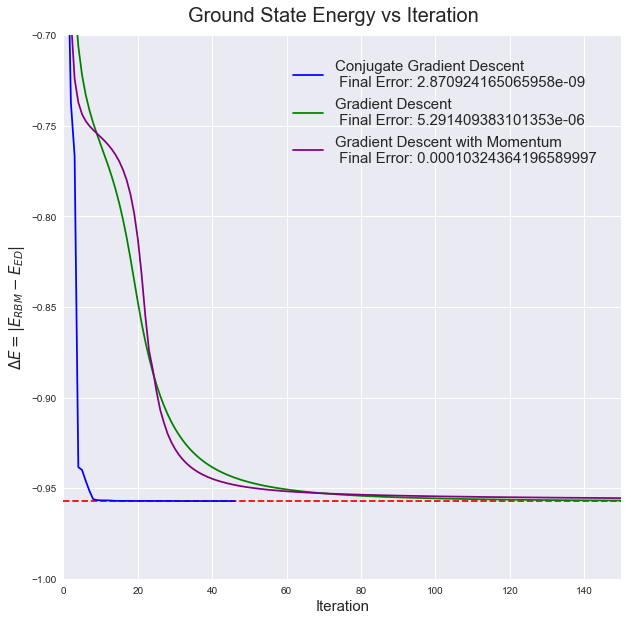

In [265]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle('Ground State Energy vs Iteration',size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])
CGDLabel = 'Conjugate Gradient Descent\n Final Error: ' + str(CGDErr[0])
GDLabel = 'Gradient Descent\n Final Error: ' + str(GDErr[0])
GDMLabel = 'Gradient Descent with Momentum\n Final Error: ' + str(GDMErr[0])
labels = [CGDLabel ,GDLabel, GDMLabel]


ax1 = plt.subplot(gs[0, :])
ax1.set_ylim(-1,-0.7)
ax1.set_xlim(0,150)
ax1.plot(iter, energyCGD, color= 'blue', label=labels[0]) 
ax1.plot(iter, energyGD, color= 'green', label=labels[1]) 
ax1.plot(iter, energyGDM, color= 'purple', label=labels[2]) 
ax1.hlines(ed[0][0],0,numIter, "r", linestyle = "--")
ax1.set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax1.set_xlabel('Iteration',size = 15)
plt.legend(labels, loc = (0.4, 0.75),fontsize = 15,ncol=1)

## Comparison Histograms

In [39]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1

gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

edState = []
edTime = []
ActualEng = []

nmState = []
nmTime = []
nmEngErr = []
nmStateErr = []

nwState = []
nwTime = []
nwEngErr = []
nwStateErr = []

bfState = []
bfTime = []
bfEngErr = []
bfStateErr = []

hisIt = np.arange(50)

In [40]:
for i in range(len(hisIt)):
    #gradient descent
    gd = minLoader('GradDescent', N, M, B, A0)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    #Nelder Mead
    nm = minLoader('NelderMead', N, M, B, A0)
    nmState.append(nm[0])
    nmTime.append(nm[1])
    
    #BFGS
    bf = minLoader('BFGS', N, M, B, A0)
    bfState.append(bf[0])
    bfTime.append(bf[1])
    
    #Newton-CG
    #newtonCG = NewtonCG(N,B,A0)
    #nw = newtonCG(N,M)
    #nwState.append(nw[0])
    #nwTime.append(nw[1])
    
    
    #Error
    gdEngTemp = gd[0][2]
    nmEngTemp = nm[0][2]
    bfEngTemp = bf[0][2]
    edEngTemp = ed[0][0]
    #nwEngTemp = nw[0][2]
    
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    nmStateTemp = nm[0][1]
    bfStateTemp = bf[0][1]
    #nwStateTemp = nw[0][1]
    
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    nmErrTemp = err(nmStateTemp,edStateTemp,nmEngTemp,edEngTemp)
    bfErrTemp = err(bfStateTemp,edStateTemp,bfEngTemp,edEngTemp)
    #nwErrTemp = err(nwStateTemp,edStateTemp,nwEngTemp,edEngTemp)
    
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])
    nmEngErr.append(nmErrTemp[0])
    nmStateErr.append(nmErrTemp[1])
    bfEngErr.append(bfErrTemp[0])
    bfStateErr.append(bfErrTemp[1])
    #nwEngErr.append(nwErrTemp[0])
    #nwStateErr.append(nwErrTemp[1])


Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 32
         Function evaluations: 840
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 223
         Function evaluations: 492
Optimization terminated successfully.
         Current function value: -1.820793
         Iterations: 18
         Function evaluations: 228
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -1.898415
         Iterations: 16
         Function evaluations: 432
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 745
         Function evaluations: 1217
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 17
         Function evaluations: 216
         Gradient evaluations: 18
Optimization terminat

Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 218
         Function evaluations: 465
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 67
         Function evaluations: 924
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 23
         Function evaluations: 636
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 926
         Function evaluations: 1463
Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 35
         Function evaluations: 528
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 19
         Function evaluations: 552
         Gradient evaluations: 46
Optimization terminat

Optimization terminated successfully.
         Current function value: -1.898451
         Iterations: 32
         Function evaluations: 408
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: -1.820754
         Iterations: 6
         Function evaluations: 264
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -1.820796
         Iterations: 242
         Function evaluations: 524
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 34
         Function evaluations: 420
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: -1.898451
         Iterations: 20
         Function evaluations: 516
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: -1.820792
         Iterations: 4
         Function evaluations: 108
         Gradient evaluat

In [41]:
stateErr = [gdStateErr, nmStateErr, bfStateErr]
engErr = [gdEngErr, nmEngErr, bfEngErr]
runTime = [gdTime, nmTime, bfTime]

Text(0, 0.5, 'Runtime')

<Figure size 432x288 with 0 Axes>

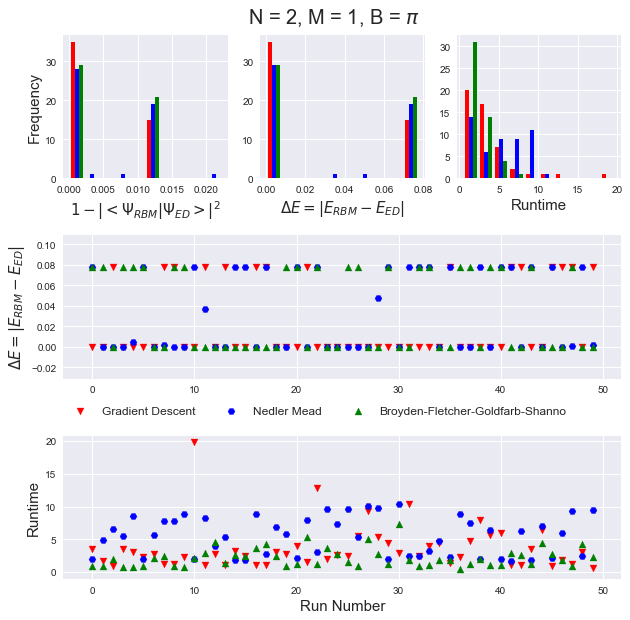

In [42]:


labels = ['Gradient Descent','Nedler Mead', 'Broyden-Fletcher-Goldfarb-Shanno']
colors = ['red','blue','green']
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.4)
ttl.set_position([.5, 0.92])



ax1 = plt.subplot(gs[0, 0])
ax1 .hist(stateErr, bins=10, label=labels, color=colors) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1.set_ylabel("Frequency",size = 15)



ax2 = plt.subplot(gs[0, 1])
ax2.hist(engErr, bins=10, color=colors) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)



ax3 = plt.subplot(gs[0, 2])
ax3.hist(runTime, bins=10,color=colors) 
ax3.set_xlabel("Runtime",size = 15)


ax4 = plt.subplot(gs[1, :])
ax4.scatter(hisIt,engErr[0],color=colors[0],marker ='v') 
ax4.scatter(hisIt,engErr[1],color=colors[1],marker ='H') 
ax4.scatter(hisIt,engErr[2],color=colors[2],marker = '^') 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)


plt.legend(labels, loc = (0, -0.3),fontsize = 12,ncol=3)

ax5 = plt.subplot(gs[2, :])
ax5.scatter(hisIt,runTime[0],color=colors[0],marker ='v') 
ax5.scatter(hisIt,runTime[1],color=colors[1],marker ='H') 
ax5.scatter(hisIt,runTime[2],color=colors[2],marker = '^') 
ax5.set_xlabel("Run Number",size = 15)
ax5 .set_ylabel("Runtime", size = 15)










